<h1> Modelling and evaluation </h1>
<h2> 1. Importing libraries and downloading datasets </h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score as ACC
from sklearn.ensemble import RandomForestClassifier

from tensorflow import keras
from keras import layers
from keras.layers import RNN, Dense, Dropout, BatchNormalization
from keras import Sequential, layers, Input, callbacks

from xgboost import XGBClassifier 
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import cross_val_score

from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Embedding,Dense

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Flatten ,Embedding,Input
from keras.models import Model

from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')

In [62]:
# Importing all the datasets
A_tra_X = pd.read_csv('data/train_A.csv')
A_val_X = pd.read_csv('data/val_A.csv')
A_test_X = pd.read_csv('data/test_A.csv')


B_tra_X = pd.read_csv('data/train_B.csv')
B_val_X = pd.read_csv('data/val_B.csv')
B_test_X = pd.read_csv('data/test_B.csv')


C_tra_X = pd.read_csv('data/train_C.csv')
C_val_X = pd.read_csv('data/val_C.csv')
C_test_X = pd.read_csv('data/test_C.csv')


D_tra_X = pd.read_csv('data/train_D.csv')
D_val_X= pd.read_csv('data/val_D.csv')
D_test_X = pd.read_csv('data/test_D.csv')

tra_y = pd.read_csv('data/train_y.csv')
val_y = pd.read_csv('data/val_y.csv')
test_y = pd.read_csv('data/test_y.csv')

tra_y_eye = np.eye(10)[list(tra_y['0'])]
val_y_eye = np.eye(10)[list(val_y['0'])]
test_y_eye = np.eye(10)[list(test_y['0'])]

<h2> 2. Benchmarks </h2>
<h3> 2.1 Naive Benchmark, Monte Carlo Method </h3>
<p> Using 1000 simulations with random guesses on target labels. </p>

In [3]:
def naive_benchmark_MonC(y):
    accuracy_list = []
    for i in range(0,1000,1):
        naive_rand_pred = np.random.randint(0,12,size=(len(y)))
        accuracy_sel = ACC(naive_rand_pred, y)
        accuracy_list.append(accuracy_sel)
    return np.mean(accuracy_list)

In [4]:
naive_benchmark_MonC(test_y)

0.08315384615384615

<h3> 2.2 Naive Benchmark, Majority Class Method </h3>
<p> Using Frodo, which equals label 2, as guess </p>

In [5]:
def naive_benchmark_MajC(y):                
    pred_MCNB =np.repeat(2,len(y))
    return ACC(pred_MCNB, y)

In [6]:
naive_benchmark_MajC(test_y)

0.1752136752136752

<h2> 3. Modelling  </h2>
<!-- <h3> 3.1 ANN on dataset A</h3> -->
<!-- <p> Dataset A contains various numerical retrieved from the characters. </p>
<p> The feedforward neural network has a relative simple architecture. -->

<h3> 3.1 XGBC on dataset D

In [7]:
p_g = {
    'objective':['multi:softprob'],
    'alpha': hp.uniform('alpha',0,1),
    'gamma': hp.uniform('gamma',0,9),
    'reg_lambda':hp.quniform('reg_lamda',0,3,1),
    'max_depth':hp.quniform('max_depth',6,12,1),
    'learning_rate': hp.uniform('learning_rate',0.001,0.05),
    'n_estimators': hp.quniform('n_estimators', 5,500,1),
    'min_child_weight': hp.quniform('min_child_weight',0,5,1),
    'seed':42
    }

In [8]:
def bayopt_xgb(p_g):
    internal_model = XGBClassifier(
                     objective='multi:softmax',
                     alpha=p_g['alpha'],
                     gamma=p_g['gamma'],
                     reg_lambda= p_g['reg_lambda'],
                     max_depth = int(p_g['max_depth']),
                     n_estimator = (p_g['n_estimators']),
                     learning_rate=p_g['learning_rate'],
                     min_child_weight=p_g['min_child_weight'],
                     seed =p_g['seed'],
                     )

    internal_model.fit(D_tra_X, tra_y,
                     eval_set = [(D_val_X, val_y)],
                     eval_metric = 'mlogloss',
                     early_stopping_rounds=25,verbose=False)
    
    # pred_valid = internal_model.predict(A2)
    # score = ACC(pred_valid, A_tra_y)

    score =np.mean(cross_val_score(internal_model, D_tra_X, tra_y, scoring='accuracy', cv=3))
    print('Score:', score)
    return {'loss':-score, 'status':STATUS_OK}

def tune():
    trials = Trials()
    best_tune = fmin(fn=bayopt_xgb, 
                    space=p_g,
                    algo= tpe.suggest,
                    max_evals=10,
                    trials=trials)
    return best_tune


ntune = tune()
ntune['n_estimators'] =  int(ntune['n_estimators'])
ntune['max_depth'] =  int(ntune['max_depth'])
xmodel = XGBClassifier(**ntune)

Score:                                                
0.2876710456167211                                    
Score:                                                                           
0.2397463763163051                                                               
Score:                                                                           
0.24845187483766898                                                              
Score:                                                                           
0.24409115142236137                                                              
Score:                                                                           
0.22668471103941967                                                              
Score:                                                                           
0.2458386304503347                                                               
Score:                                                                

In [9]:
xmodel.fit(D_tra_X, tra_y)

XGBClassifier(alpha=0.18095745420879883, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.48847450117437485, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03134063584093455,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=2.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=351, n_jobs=None,
              num_parallel_tree=None, ...)

In [10]:
print('Accuracy train: ',ACC(xmodel.predict(D_tra_X),tra_y))
print('Accuracy validation: ',ACC(xmodel.predict(D_val_X),val_y))
print('Accuracy test: ',ACC(xmodel.predict(D_test_X),test_y))

Accuracy train:  0.4864864864864865
Accuracy validation:  0.3031496062992126
Accuracy test:  0.2948717948717949


<h3> 3.2 RNN on dataset B </h3>
<p> Dataset B contains embeddings(?). This, I need to read myself up on.</p>

In [90]:
ann_model = keras.Sequential([
    layers.Dense(20, activation='relu',input_dim=20),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(16, activation='gelu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(8, activation='relu'),
    # layers.BatchNormalization(),
    # layers.Dropout(0.3),
    # layers.Dense(254, activation='gelu'),
    # layers.BatchNormalization(),
    # layers.Dropout(0.3),
    layers.Dense(10, activation='softmax'),
    # layers.Dense(10)
])

optimizer = keras.optimizers.Adam(learning_rate=0.03)
ann_model.compile(optimizer=optimizer,
              loss = 'categorical_crossentropy',
              metrics=['accuracy']
              )

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=30, # how many epochs to wait before stopping
    restore_best_weights=True,
)
history = ann_model.fit(A_tra_X, tra_y_eye, 
          validation_data= (A_val_X, val_y_eye),
          epochs=150, batch_size=30, 
          callbacks=early_stopping,
          verbose=1
          )


Epoch 1/150


39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1272 - loss: 2.4302 - val_accuracy: 0.2008 - val_loss: 2.2952
Epoch 2/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1488 - loss: 2.2557 - val_accuracy: 0.1339 - val_loss: 2.2578
Epoch 3/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1432 - loss: 2.2458 - val_accuracy: 0.1417 - val_loss: 2.2298
Epoch 4/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1478 - loss: 2.2543 - val_accuracy: 0.1654 - val_loss: 2.1975
Epoch 5/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1464 - loss: 2.2424 - val_accuracy: 0.1496 - val_loss: 2.2072
Epoch 6/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1584 - loss: 2.2360 - val_accuracy: 0.1850 - val_loss: 2.2078
Epoch 7/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1644 - loss: 2.2291 - val_accuracy: 0.1772 - val_loss: 2.2103
Epoch 8/150
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1499 - loss: 2.2375 - val_accuracy: 0.1378 - val_loss: 2.2

In [67]:
# ann.mode

In [68]:
# emb_model = Sequential([
#     layers.Embedding(input_dim=2500, output_dim=10, input_length=B_tra_X.shape[1]),
#     # layers.Flatten(),
#     layers.SimpleRNN(4,activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0,3),
#     layers.Dense(8, activation='selu'),
#     # layers.BatchNormalization(),
#     # layers.Dropout(0.3),
#     # layers.Dense(64, activation='gelu'),
#     # layers.BatchNormalization(),
#     # layers.Dropout(0.3),
#     layers.Dense(10, activation='softmax')
# ])

# optimizer = keras.optimizers.Adam(learning_rate=0.01)
# emb_model.compile(optimizer=optimizer, 
#             loss='categorical_crossentropy', 
#             metrics=['accuracy'])
# # 
# early_stopping = callbacks.EarlyStopping(
#     min_delta=0.01, # minimium amount of change to count as an improvement
#     patience=5, # how many epochs to wait before stopping
#     restore_best_weights=True,
# )

# emb_model.fit(D_tra_X,tra_y_eye, epochs=50, batch_size=80, 
#         validation_data=(D_val_X, val_y_eye),
#         callbacks=early_stopping,)

In [69]:
# emb_model.summary()

In [71]:
# Train accuracy
ann_model.evaluate(A_tra_X, tra_y_eye)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1690 - loss: 2.2226 


[2.2240731716156006, 0.17175239324569702]

In [73]:
# Validation accuracy
ann_model.evaluate(A_val_X, val_y_eye)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1646 - loss: 2.2247 


[2.191230297088623, 0.20078739523887634]

In [72]:
# Test accuracy
ann_model.evaluate(A_test_X, test_y_eye)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1935 - loss: 2.1670 


[2.193082094192505, 0.19230769574642181]

<p> sources </p>
<ul>
<li>https://keras.io/api/models/model/</li>
<li>https://towardsdatascience.com/machine-learning-word-embedding-sentiment-classification-using-keras-b83c28087456</li>
<li>https://www.kaggle.com/code/rajmehra03/a-detailed-explanation-of-keras-embedding-layer</li>
<li>https://medium.com/@iqra.bismi/understanding-keras-embedding-for-natural-language-processing-9f65a281b1a7</li>

</ul>

<h3> 3.3 RFC on dataset C </h3>
<p>  Dataset C contains a counter on how many times a specific word have been mentioned in a quote. </p>

In [16]:
A_tra_X.shape

(1152, 20)

In [17]:
B_tra_X.shape

(1147, 2514)

In [18]:
C_tra_X.shape

(1147, 2697)

In [19]:
D_tra_X.shape

(1147, 2697)

In [20]:
param_grid = {
    'n_estimators': [30,35,45],
    'max_depth': [6,9,12,15,16],
}

acc_list = []
for n in range(len(param_grid['n_estimators'])):
    nE = param_grid['n_estimators'][n]
    for d in range(len(param_grid['max_depth'])):
        mD = param_grid['max_depth'][d]
        
        model = RandomForestClassifier(n_estimators=nE, max_depth=mD, random_state=42) 
        model.fit(D_tra_X, tra_y)
        X1 = model.predict(D_tra_X)
        x2 = model.predict(D_val_X)
        acc_list.append(ACC(x2, val_y))


In [21]:
from sklearn.model_selection import GridSearchCV

In [22]:
C_train = pd.concat([C_tra_X, C_val_X],axis=0).reset_index(drop=True)
C_target = pd.concat([tra_y, val_y],axis=0).reset_index(drop=True)

# C_target

In [23]:

rfc = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy', 
                           n_jobs=-1, error_score='raise')
grid_search.fit(C_train, C_target)

GridSearchCV(cv=5, error_score='raise',
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [6, 9, 12, 15, 16],
                         'n_estimators': [30, 35, 45]},
             scoring='accuracy')

In [24]:
best_params = grid_search.best_params_
best_params

{'max_depth': 16, 'n_estimators': 45}

In [25]:
rfc_model = RandomForestClassifier(**best_params)
rfc_model.fit(C_train, C_target)
train_pred = rfc_model.predict(C_train)
test_pred = rfc_model.predict(C_test_X)

In [26]:
print('Accuracy train:',ACC(train_pred, C_target))
print('Accuracy test:',ACC(test_pred, test_y))

Accuracy train: 0.5753033547466095
Accuracy test: 0.3547008547008547


<h2> 4. Ensemble model </h2>
<p> The RFC contains absolutely best results therefore, they will have prioritized votes if there are ties. </p>

In [91]:
# XGBC
P1 = xmodel.predict(D_test_X)

# LSTM
pp2 = ann_model.predict(A_test_X)
P2 = pp2.argmax(axis=1)

# RFC
P3 = rfc_model.predict(C_test_X)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [92]:
final_preds = []
for i in range(len(P1)):
    preds =  [P1[i],P2[i],P3[i]]
    if preds[0]==preds[1]:
        ans = preds[0]
    elif preds[0]==preds[2]:
        ans= preds[0]
    elif preds[1]==preds[2]:
        ans=preds[1]
    else:
        ans = preds[2]
    final_preds.append(ans)
ACC(final_preds, test_y)

0.36324786324786323

In [76]:
def evaluate_model(pred, target):
    eval_methods = [ f1_score, precision_score, recall_score]

    print(classification_report(pred, target))
    print("Accuracy ", round(ACC(pred, target), 4)) 
    
    for e in eval_methods:
        print(str(e.__name__), round(e(pred, target, average='weighted'), 4)) 
    # return pred  

In [77]:
imp_char = ["FRODO", "SAM", "GANDALF", "PIPPIN", "MERRY", "GOLLUM", "GIMLI", "THEODEN", "FARAMIR", "ARAGORN"]

def conf_matrix(y, pred):
    cm = confusion_matrix(pred,y)
    fig, ax = plt.subplots(figsize=(10,10)) 
    sns.heatmap(cm/np.sum(cm), annot=True, 
                fmt='.1%', cmap='Blues', ax=ax, 
                xticklabels=imp_char, yticklabels=imp_char)
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.show()

In [78]:
# D_tra_X['and'].unique()

In [79]:
def part_A(A,B,C):
    obs_tot_list = []
    for i in range(0,len(A),1):
        ptot_list = []
        for j  in range(0,10,1):
            p1 = A[j][i]
            p2  = B[j][i]
            p3 = C[j][i]
            ptot = sum([p1,p2,p3])
            ptot_list.append(ptot)
        obs_tot_list.append(ptot_list)
    return obs_tot_list
    

In [80]:
a = xmodel.predict_proba(D_test_X)
b = emb_model.predict(D_test_X)
c = rfc_model.predict_proba(C_test_X)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


<h2> results: </h2>
<h3> XGBC

In [81]:
evaluate_model(P1, test_y)

              precision    recall  f1-score   support

           0       0.39      0.13      0.19        87
           1       0.00      0.00      0.00         2
           2       0.34      0.54      0.42        26
           3       0.45      0.50      0.48        30
           4       0.00      0.00      0.00         1
           5       0.61      0.38      0.47        29
           6       0.07      0.12      0.09         8
           7       0.17      0.21      0.19        19
           8       0.32      0.46      0.38        26
           9       0.06      0.17      0.09         6

    accuracy                           0.29       234
   macro avg       0.24      0.25      0.23       234
weighted avg       0.37      0.29      0.30       234

Accuracy  0.2949
f1_score 0.2995
precision_score 0.3716
recall_score 0.2949


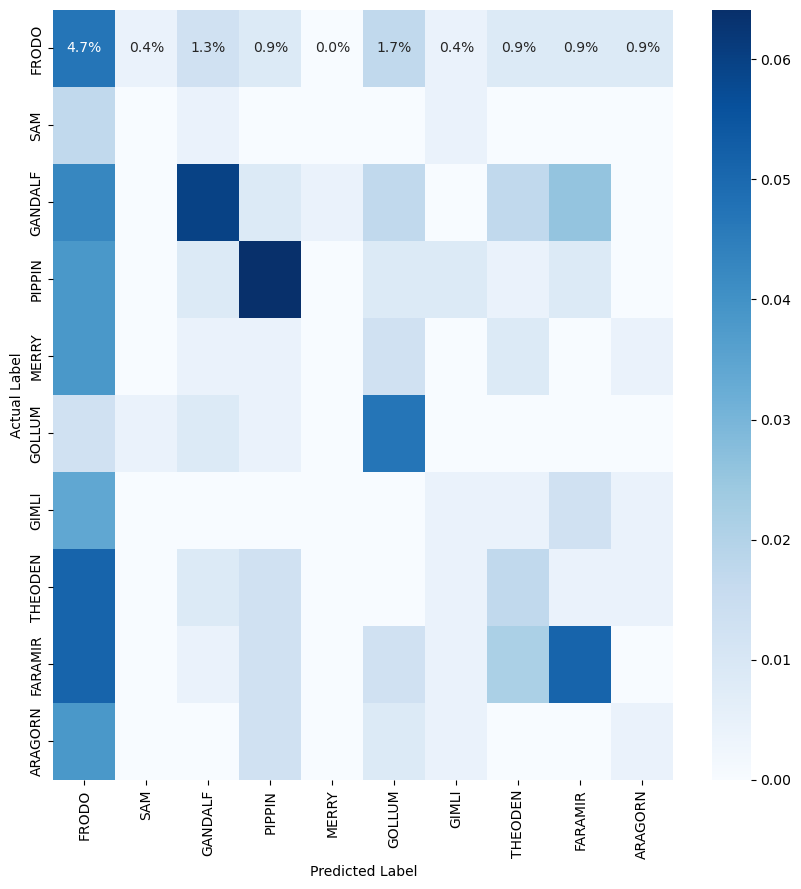

In [82]:
conf_matrix(P1, test_y)

<h3> RNN

In [83]:
evaluate_model(P2, test_y)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.49      0.18      0.26       112
           3       0.64      0.25      0.36        83
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.11      0.10      0.11        39
           9       0.00      0.00      0.00         0

    accuracy                           0.19       234
   macro avg       0.12      0.05      0.07       234
weighted avg       0.48      0.19      0.27       234

Accuracy  0.1923
f1_score 0.2711
precision_score 0.4772
recall_score 0.1923


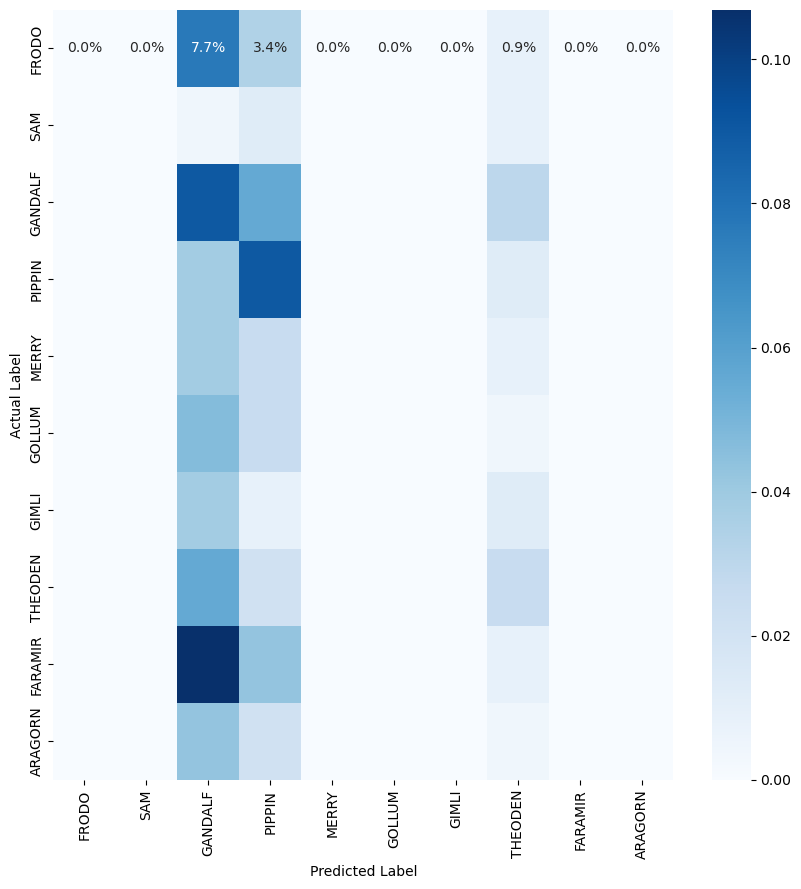

In [94]:
conf_matrix(P2, test_y)

<h3> RFC

In [95]:
evaluate_model(P3, test_y)

              precision    recall  f1-score   support

           0       0.14      0.44      0.22         9
           1       0.00      0.00      0.00         0
           2       0.78      0.26      0.39       122
           3       0.48      0.42      0.45        38
           4       0.00      0.00      0.00         0
           5       0.67      0.46      0.55        26
           6       0.00      0.00      0.00         1
           7       0.12      0.75      0.21         4
           8       0.41      0.45      0.43        33
           9       0.06      1.00      0.12         1

    accuracy                           0.35       234
   macro avg       0.27      0.38      0.24       234
weighted avg       0.62      0.35      0.41       234

Accuracy  0.3547
f1_score 0.4114
precision_score 0.6248
recall_score 0.3547


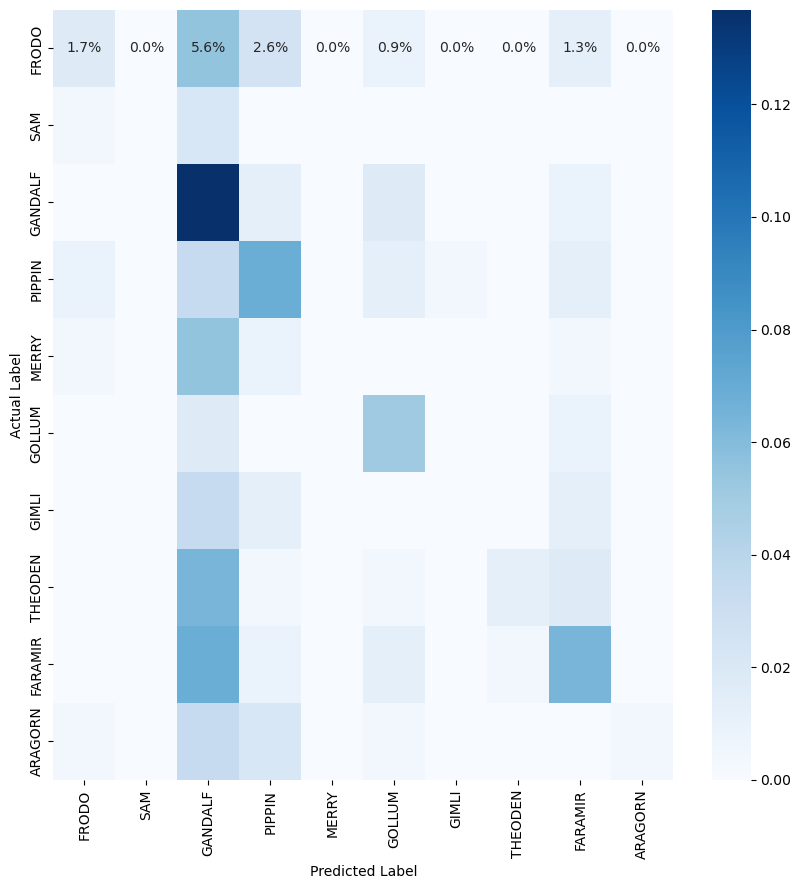

In [96]:
conf_matrix(P3, test_y)

<h3> Ensemble


In [97]:
evaluate_model(final_preds, test_y)

              precision    recall  f1-score   support

           0       0.14      0.44      0.22         9
           1       0.00      0.00      0.00         0
           2       0.76      0.26      0.39       119
           3       0.61      0.43      0.50        47
           4       0.00      0.00      0.00         0
           5       0.67      0.48      0.56        25
           6       0.00      0.00      0.00         1
           7       0.17      0.57      0.26         7
           8       0.35      0.52      0.42        25
           9       0.06      1.00      0.12         1

    accuracy                           0.36       234
   macro avg       0.28      0.37      0.25       234
weighted avg       0.63      0.36      0.42       234

Accuracy  0.3632
f1_score 0.4185
precision_score 0.6258
recall_score 0.3632


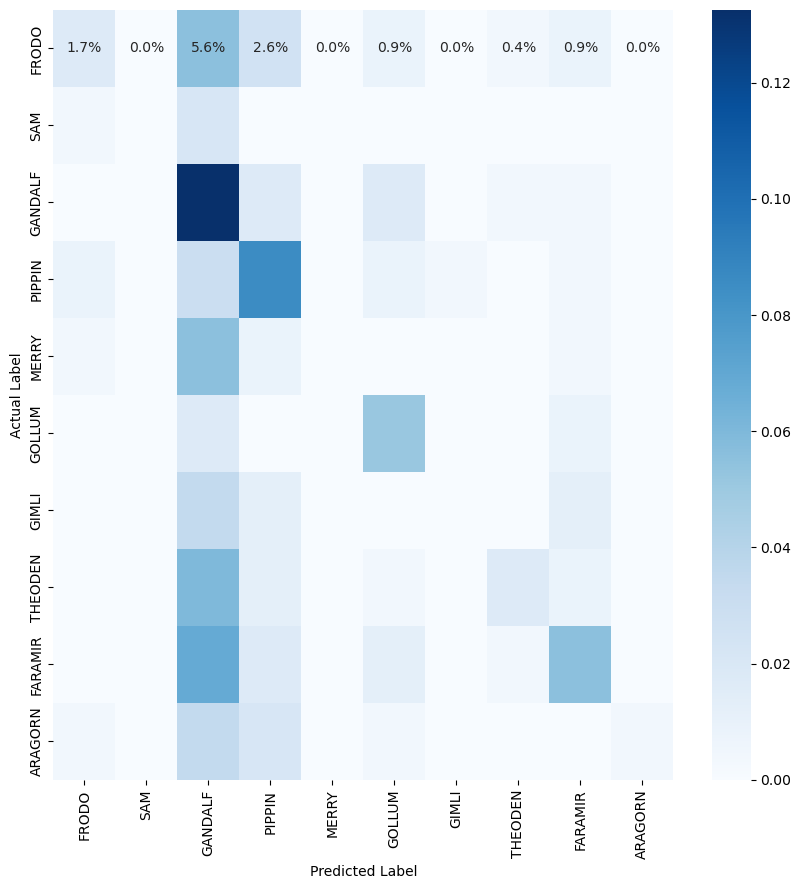

In [98]:
conf_matrix(final_preds, test_y)

<h2> naive mbenchmark majority class

In [99]:
evaluate_model(test_y, np.repeat(2,len(final_preds)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.00      0.00      0.00         6
           2       0.18      1.00      0.30        41
           3       0.00      0.00      0.00        33
           4       0.00      0.00      0.00        17
           5       0.00      0.00      0.00        18
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        24
           8       0.00      0.00      0.00        37
           9       0.00      0.00      0.00        16

    accuracy                           0.18       234
   macro avg       0.02      0.10      0.03       234
weighted avg       0.03      0.18      0.05       234

Accuracy  0.1752
f1_score 0.0522
precision_score 0.0307
recall_score 0.1752


<h1> 5. Conclusion: </h1>
<p> We have used three different datasets trained on three different models. The best individual model is the random forest classifier, which is trained on dummy coded BoW. </p>
<br>
<p> Furthermore, all the models have been put together in an ensemble model, where the majority class wins. The accuracy of the ensemble model is equal to the accuracy retrieved from the rfc model. This might indicate that there are no documents where the two other models agrees upon another label than the rfc model. In other words; the other models are do not give any type of additional explanatory power other what than the rfc model gives.</p>
<br>
<p> The upside of the modelling phase is that we have been able to create a model that is better than random guessing by 300% and a model that better than guessing Frodo all the time by approximately 100%. </p>
<br>
<h1> Biological hazard have left the building at 01:55.  </h1>